In [11]:
import google.generativeai as genai
import pandas as pd
import time
import os
import json
import re
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=API_KEY)
model = genai.GenerativeModel('gemini-2.5-flash')

In [ ]:
INPUT_FILE = "qwen_v2_predictions_for_eval.csv"
OUTPUT_FILE = "ket_qua_cham_diem.xlsx"

EVAL_PROMPT_TEMPLATE = """
Bạn là một chuyên gia dịch thuật Anh-Việt. Hãy chấm điểm bản dịch sau đây.

- Câu gốc (Tiếng Anh): "{src}"
- Bản dịch của máy (Tiếng Việt): "{hyp}"
- Đáp án tham khảo (nếu cần): "{ref}"

Yêu cầu:
1. Chấm điểm độ chính xác và sự tự nhiên trên thang điểm 1-10 (số nguyên).
2. Đưa ra nhận xét ngắn gọn (dưới 20 từ) về chất lượng.

BẮT BUỘC trả về định dạng JSON như sau:
{{
  "score": 8,
  "comment": "Dịch đúng nghĩa nhưng từ ngữ chưa mượt."
}}
"""

def clean_json_string(text):
    text = re.sub(r"```json|```", "", text).strip()
    return text

In [ ]:
if not os.path.exists(INPUT_FILE):
    print(f"file not found: '{INPUT_FILE}'")
    print("please upload or place file in same directory")
else:
    print(f"reading file '{INPUT_FILE}'...")
    df = pd.read_csv(INPUT_FILE)
    
    src_col = 'src' if 'src' in df.columns else 'English'
    hyp_col = 'hyp' if 'hyp' in df.columns else 'Qwen_Translation'
    ref_col = 'ref' if 'ref' in df.columns else 'Vietnamese'
    
    print(f"number of rows: {len(df)}")
    print(f"columns used: {src_col} (source), {hyp_col} (machine translation)")
    
    display(df.head())

📖 Đang đọc file 'qwen_v2_predictions_for_eval.csv'...
ℹ️ Số lượng dòng dữ liệu: 50
ℹ️ Các cột được sử dụng: src (Gốc), hyp (Dịch máy)


,src,hyp,ref
0,The sick man required constant attention,<think>\n\n</think>\n\nngười bệnh cần tiếp tục...,người bệnh cần chú ý liên tục
1,The teacher encouraged me to study abroad,<think>\n\n</think>\n\ngiáo viên khuyến khích ...,giáo viên khuyến khích tôi đi du học
2,Tom collects stamps,<think>\n\n</think>\n\ntom sưu tập tem,tom sưu tập tem
3,When was your most recent dental appointment?,<think>\n\n</think>\n\nLịch hẹn gần nhất của b...,Lần hẹn gần đây nhất của bạn là khi nào?
4,Tom wiped the blood off his sword,<think>\n\n</think>\n\nTom lau máu ra khỏi con...,tom lau máu khỏi thanh kiếm của mình


In [ ]:
results = []

print(f"starting evaluation for {len(df)} sentences...")

for index, row in tqdm(df.iterrows(), total=len(df), desc="progress"):
    src = row[src_col]
    hyp = row[hyp_col]
    ref = row[ref_col] if ref_col in df.columns else ""

    prompt = EVAL_PROMPT_TEMPLATE.format(src=src, hyp=hyp, ref=ref)

    try:
        response = model.generate_content(prompt)
        
        json_str = clean_json_string(response.text)
        eval_data = json.loads(json_str)
        
        score = eval_data.get("score", 0)
        comment = eval_data.get("comment", "")

    except Exception as e:
        score = -1
        comment = f"Error: {str(e)}"

    results.append({
        "Tiếng Anh": src,
        "Qwen Dịch": hyp,
        "Điểm (1-10)": score,
        "Nhận xét của Gemini": comment
    })

    time.sleep(4)

print("\nevaluation completed")

🚀 Bắt đầu chấm điểm 50 câu...








































































































Tiến độ: 100%|██████████| 50/50 [08:41<00:00, 10.42s/it]


✅ Đã hoàn thành quá trình chấm điểm!


In [ ]:
df_result = pd.DataFrame(results)

print(f"saving results to '{OUTPUT_FILE}'...")
df_result.to_excel(OUTPUT_FILE, index=False)

valid_scores = df_result[df_result["Điểm (1-10)"] >= 0]["Điểm (1-10)"]
avg_score = valid_scores.mean()

print("="*30)
print(f"average score: {avg_score:.2f} / 10")
print("="*30)

display(df_result.head())

💾 Đang lưu kết quả vào 'ket_qua_cham_diem.xlsx'...
⭐ Điểm trung bình: 7.66 / 10


,Tiếng Anh,Qwen Dịch,Điểm (1-10),Nhận xét của Gemini
0,The sick man required constant attention,<think>\n\n</think>\n\nngười bệnh cần tiếp tục...,8,Nghĩa đúng nhưng từ 'tiếp tục' chưa lột tả hết...
1,The teacher encouraged me to study abroad,<think>\n\n</think>\n\ngiáo viên khuyến khích ...,10,Bản dịch hoàn toàn chính xác về nghĩa và rất t...
2,Tom collects stamps,<think>\n\n</think>\n\ntom sưu tập tem,10,"Bản dịch hoàn toàn chính xác và rất tự nhiên, ..."
3,When was your most recent dental appointment?,<think>\n\n</think>\n\nLịch hẹn gần nhất của b...,8,Dịch đúng nghĩa nhưng thiếu chi tiết 'nha khoa...
4,Tom wiped the blood off his sword,<think>\n\n</think>\n\nTom lau máu ra khỏi con...,7,"Dịch sai từ 'sword' thành 'dao', làm thay đổi ..."


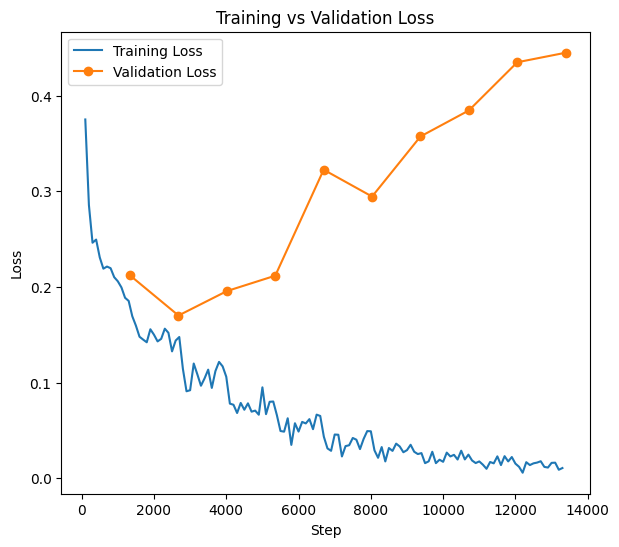

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd

with open('phobert_toxic_result/checkpoint-13390/trainer_state.json', 'r') as f:
    data = json.load(f)

history = data['log_history']

train_data = []
eval_data = []

for entry in history:
    if 'loss' in entry:
        train_data.append(entry)
    if 'eval_loss' in entry:
        eval_data.append(entry)

df_train = pd.DataFrame(train_data)
df_eval = pd.DataFrame(eval_data)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df_train['step'], df_train['loss'], label='Training Loss')
plt.plot(df_eval['step'], df_eval['eval_loss'], label='Validation Loss', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

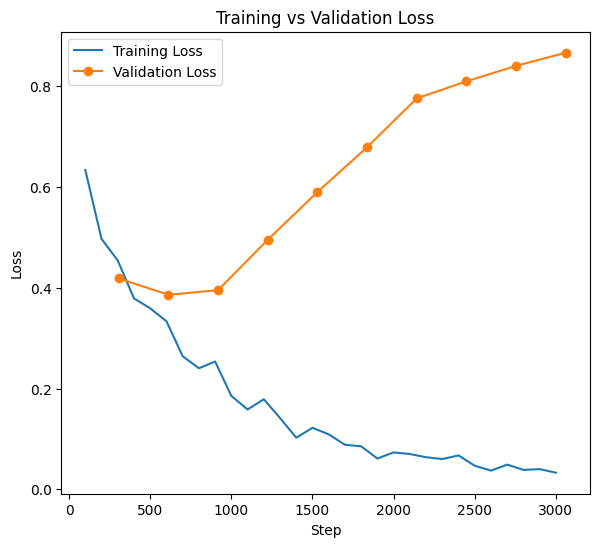

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd

with open('phobert_toxic_result_10k/checkpoint-3060/trainer_state.json', 'r') as f:
    data = json.load(f)

history = data['log_history']

train_data = []
eval_data = []

for entry in history:
    if 'loss' in entry:
        train_data.append(entry)
    if 'eval_loss' in entry:
        eval_data.append(entry)

df_train = pd.DataFrame(train_data)
df_eval = pd.DataFrame(eval_data)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df_train['step'], df_train['loss'], label='Training Loss')
plt.plot(df_eval['step'], df_eval['eval_loss'], label='Validation Loss', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()